In [1]:
import numpy as np
import locale
import copy
import matplotlib.pyplot as plt
from math import floor, log10, ceil
from scipy import special, optimize
from scipy.integrate import solve_bvp, quad, ode
from scipy.interpolate import make_interp_spline

# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "ru_RU")
plt.rcParams.update({"font.size": 13})
params = {"text.latex.preamble": r"\usepackage{icomma}"}
plt.rcParams["axes.formatter.use_locale"] = True
plt.rcParams.update(params)

props = dict(boxstyle="square", facecolor="white")
props_note = dict(boxstyle="ellipse", facecolor="white")

eV_to_J = 1.6e-19
eV_to_K = 11604
J_to_eV = 6.242e18
eV_to_erg = 1.602e-12
erg_to_eV = 6.242e11
K_to_erg = 1.381e-16
erg_to_K = 7.243e15
Cl_to_SGS = 3.0e9

def TK(T):  # dimensionless form temperature to [K]
    return T * Te * erg_to_K


def TD(T):  # [K] temperature to dimensionless form
    return T / Te * K_to_erg

##### Physical properties
me = 9.11e-28  # electron mass
mi = 1.67e-24  # ion(proton) mass
e = 1.6e-19 * Cl_to_SGS  # electric charge of electron
a = 120.4 / K_to_erg**2 * Cl_to_SGS  # Richardson's constant
sigma = 5.67e-5 # Stefan-Boltzmann constant
phiout = 4.54 * eV_to_erg  # Pa6oma

nse = 1.0e13 # plasma component density
Te = 200.0 * eV_to_erg  # electron temperature
deltae = 0  # SEE coefficient
cs = np.sqrt(Te / mi)  # Bohm's criterion velocity
# vth = np.sqrt(8 * Te / (np.pi * me))  # Thermal electron velocity

#at T = 3000
rho = 18.22
Cp = 217.8*1.0e7/1.0e3
kappa = 21.2*1.0e3 *1.0e4

##### ODE solver properties
d_net_steps = 21
d_net_max = 5.0
d_net = np.linspace(0, d_net_max, d_net_steps)
dx = d_net[1] - d_net[0]

t_net_steps = 201
t_net_max = 4 * np.pi
t_net = np.linspace(0, t_net_max, t_net_steps)
dt = t_net[1] - t_net[0]

T_th = TD(2000)

A = kappa * dt / dx**2
B = nse * cs * Te * dx / kappa

r_debye = np.sqrt(Te / (4 * np.pi * nse * e**2))

In [2]:
def nte_w_func(derw, Tw, Te, nse):
    dA = -np.sign(derw) * np.sqrt(abs(derw)) * np.sqrt(e * Te / r_debye) * 300
    # print(dA * Te * erg_to_eV, phiout * erg_to_eV)
    return (
        a
        * (Tw * Te) ** 2.0
        * np.exp(-(phiout / Te + dA) / Tw)
        / (0.25 * e * nse * np.sqrt(Tw * Te * 8.0 / np.pi / me))
    )


def upsilon_0_func(phi_se):
    return np.sqrt(-2.0 * phi_se) if (phi_se < 0) else 0.0


def erfcxexp_limit_resolve(x):
    if x > 200:
        return (
            np.power(x, -0.5)
            - np.power(x, -1.5) / 2.0
            + np.power(x, -2.5) * 3.0/4.0
            - np.power(x, -3.5) * 15.0/8.0
            + np.power(x, -4.5) * 105.0/16.0
        ) / np.sqrt(np.pi)
    else:
        return special.erfc(np.sqrt(x))*np.exp(x)

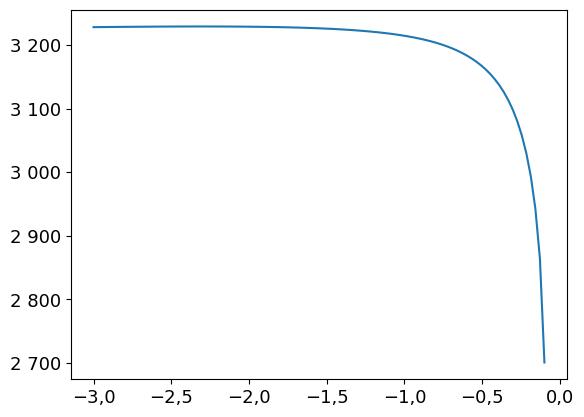

In [3]:
def Poisson_integrated_classic_trans(phi, y, args):
    V_f, n_e, Tw = y
    nse, nte_w, upsilon_0, phi_se = args
    return (
        upsilon_0 * np.sqrt(upsilon_0**2 - 2 * (phi - phi_se))
        + n_e * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * (
            erfcxexp_limit_resolve((phi - (V_f + phi_se)) / Tw)
            + 2 / np.sqrt(np.pi) * np.sqrt((phi - (phi_se + V_f)) / Tw)
        )
    )


def Poisson_classic_trans(y, args):
    V_f, n_e, Tw = y
    nse, nte_w, upsilon_0, phi_se = args
    return -2.0 * (
        Poisson_integrated_classic_trans(phi_se + V_f, y, args)
        - Poisson_integrated_classic_trans(phi_se, y, args)
    )


def quasineutrality_trans(y, args):
    V_f, n_e, Tw = y
    nse, nte_w, upsilon_0, phi_se = args
    return 1 - nte_w * erfcxexp_limit_resolve(-V_f / Tw) - n_e


def j_wall_trans(y, args):
    V_f, n_e, Tw = y
    nse, nte_w, upsilon_0, phi_se = args
    return V_f - np.log(
        4 * upsilon_0 / (n_e * np.sqrt(8 * mi / (np.pi * me)))
        + nte_w / n_e * np.sqrt(Tw)
    )



def sys_trans(y, *args):
    V_f, n_e, Tw = y
    Te, nse, phi_se = args
    args1 = [nse, nte_w_func(0, Tw, Te, nse), upsilon_0_func(phi_se), phi_se]
    return [
        # Bohm_criterion_trans(y, args1),
        Poisson_classic_trans(y, args1),
        j_wall_trans(y, args1),
        quasineutrality_trans(y, args1),
    ]

def phi_se_func(_base, _amp, _omega, _t):
    # return _base + _amp * (((_omega * _t) / (2 * np.pi)) % 1.0)
    return _base + _amp * np.sin(_omega * _t)

amp = 0.0
omega = 1.0
base = -0.5
sol_trans_init_guesses = [
    [-1.1866, 0.892, TD(3165)],
    [-1.1866, 0.892, TD(2900)],
    [-1.15, 0.9, TD(2750)],
    [-1.0, 0.9, TD(3200)],
    [-3.7, 0.999, TD(2700)]
]

phi_se_steps = 101
phi_se_net = np.linspace(-3.0, -0.1, 101)
V_f_trans_osc_net = np.zeros(phi_se_steps)
n_e_trans_osc_net = np.zeros(phi_se_steps)
Tw_trans_osc_net = np.zeros(phi_se_steps)

for i in range(phi_se_steps):
    sw_trans = False
    args_trans = (Te, nse, phi_se_net[i])
    for j in range(len(sol_trans_init_guesses)):
        sol_trans = optimize.fsolve(sys_trans, sol_trans_init_guesses[j], args=args_trans)
        if (np.isclose(sys_trans(sol_trans, *args_trans), np.zeros(len(sol_trans))) == np.ones(len(sol_trans), dtype = bool)).all():
            sw_trans = True
            break
        else:
            print(sys_trans(sol_trans, *args_trans))
    if sw_trans == False:
        raise NameError('Appropriate sol_trans not found. Add more initial guesses')
    else:
        V_f_trans_osc_net[i], n_e_trans_osc_net[i], Tw_trans_osc_net[i] = sol_trans
    
plt.plot(phi_se_net, TK(Tw_trans_osc_net))

In [4]:
def j_wall_classic(y, args):
    derw, n_e, V_f = y
    Tw, nte_w, upsilon_0, phi_se = args
    return V_f - np.log(
        4 * upsilon_0 / (n_e * np.sqrt(8 * mi / (np.pi * me)))
        + nte_w / n_e * np.sqrt(Tw)
    )

def Bohm_criterion_classic(y, args):
    derw, n_e, V_f = y
    Tw, nte_w, upsilon_0, phi_se = args
    return phi_se + 0.5 * Tw / (
        n_e * Tw
        + nte_w
        * (
            erfcxexp_limit_resolve(-V_f / Tw)
            - 1 / (np.sqrt(np.pi) * np.sqrt(-V_f / Tw))
        )
    )


def quasineutrality_classic(y, args):
    derw, n_e, V_f = y
    Tw, nte_w, upsilon_0, phi_se = args
    return 1 - nte_w * erfcxexp_limit_resolve(-V_f / Tw) - n_e


def Poisson_integrated_classic(phi, y, args):
    derw, n_e, V_f = y
    Tw, nte_w, upsilon_0, phi_se = args
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * (
            erfcxexp_limit_resolve((phi - (V_f + phi_se)) / Tw)
            + 2 / np.sqrt(np.pi) * np.sqrt((phi - (phi_se + V_f)) / Tw)
        )
    )


def Poisson_classic(y, args):
    derw, n_e, V_f = y
    Tw, nte_w, upsilon_0, phi_se = args
    return derw**2 - 2.0 * (
        Poisson_integrated_classic(phi_se + V_f, y, args)
        - Poisson_integrated_classic(phi_se, y, args)
    )


def sys_classic(y, *args):
    derw, n_e, V_f = y
    Tw, Te, nse, phi_se = args
    args1 = [Tw, nte_w_func(derw, Tw, Te, nse), upsilon_0_func(phi_se), phi_se]
    return [
        # Bohm_criterion_classic(y, args1),
        quasineutrality_classic(y, args1),
        j_wall_classic(y, args1),
        Poisson_classic(y, args1)
    ]
    
def jwall_SCL(y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    dip = (V_f - V_vc) / Tw
    return (
        upsilon_0
        - 0.25 * n_e_se * np.sqrt(8 * mi / (np.pi * me)) * np.exp(V_vc)
        + 0.25 * nte_w * np.sqrt(Tw * 8 * mi / (np.pi * me)) * np.exp(-dip)
    )  #


def quasineutrality_SCL(y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    dip = (V_f - V_vc) / Tw
    return (
        1 - n_e_se - nte_w * erfcxexp_limit_resolve(-V_vc / Tw) * np.exp(-dip)
    )  #


def Poisson_integrated_SCL_beta(phi, y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    dip = (V_f - V_vc) / Tw
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e_se * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * np.exp(-dip)
        * (
            erfcxexp_limit_resolve((phi - (V_vc + phi_se)) / Tw)
            + 2.0
            / np.sqrt(np.pi)
            * np.sqrt((phi - (V_vc + phi_se)) / Tw)
        )
    )  # ~~~


def Poisson_SCL_beta(y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    return -2 * (
        Poisson_integrated_SCL_beta(V_vc + phi_se, y, args)
        - Poisson_integrated_SCL_beta(phi_se, y, args)
    )

def Poisson_integrated_SCL_alpha(phi, y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    dip = (V_f - V_vc) / Tw
    res = (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e_se
        * (
            # np.exp(V_vc) * erfcxexp_limit_resolve(phi - (V_vc + phi_se))
            np.exp(phi - phi_se) * special.erfc(np.sqrt(phi - (V_vc + phi_se)))
            + 2.0
            / np.sqrt(np.pi)
            * (np.sqrt(phi - (V_vc + phi_se)))
            * np.exp(V_vc)
        )
        + nte_w
        * Tw
        * (
            np.exp((phi - (V_f + phi_se))/Tw) * (1 + special.erf(np.sqrt((phi - (V_vc + phi_se)) / Tw)))
            - 2.0
            / np.sqrt(np.pi)
            * (np.sqrt((phi - (V_vc + phi_se))/Tw))
            * np.exp((V_vc - V_f)/Tw)
        )
    )
    return res

def Poisson_SCL_alpha(y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    return derw**2 - 2 * (
        Poisson_integrated_SCL_alpha(V_f + phi_se, y, args)
        - Poisson_integrated_SCL_alpha(V_vc + phi_se, y, args)
    )


def sys_SCL(y, *args):
    derw, n_e_se, V_f, V_vc = y
    Tw, Te, nse, phi_se = args
    nte_w = nte_w_func(derw, Tw, Te, nse)
    upsilon_0 = upsilon_0_func(phi_se)
    args1 = [Tw, nte_w, upsilon_0, phi_se]
    return [
        quasineutrality_SCL(y, args1),
        jwall_SCL(y, args1),
        Poisson_SCL_alpha(y, args1),
        Poisson_SCL_beta(y, args1),
    ]


In [1]:
def q_ion_func(y, phi_se, Tw, Tw_trans, units = "dless"):
    derw, n_e, V_f, V_vc = y
    upsilon_0 = upsilon_0_func(phi_se)
    vth = np.sqrt(8 * mi / (np.pi * me))
    vteth = np.sqrt(8 * Tw * mi / (np.pi * me))
    q = upsilon_0 * (upsilon_0**2 / 2 - V_vc)
    if (units == "dless"):
        return q
    elif (units == "MW"):
        return q * nse * cs * Te * 1.0e13
    else:
        return q * nse * cs * Te

def q_e_func(y, phi_se, Tw, Tw_trans, units = "dless"):
    derw, n_e, V_f, V_vc = y
    upsilon_0 = upsilon_0_func(phi_se)
    vth = np.sqrt(8 * mi / (np.pi * me))
    vteth = np.sqrt(8 * Tw * mi / (np.pi * me))
    if (Tw <= Tw_trans):
        q = (
            0.25 * n_e * vth * 2 * np.exp(V_f)
        )
    else:
        q = (
            0.25 * n_e * vth * 2 * np.exp(V_vc)
        )
    if (units == "dless"):
        return q
    elif (units == "MW"):
        return q * nse * cs * Te * 1.0e13
    else:
        return q * nse * cs * Te

def q_te_func(y, phi_se, Tw, Tw_trans, units = "dless"):
    derw, n_e, V_f, V_vc = y
    upsilon_0 = upsilon_0_func(phi_se)
    vth = np.sqrt(8 * mi / (np.pi * me))
    vteth = np.sqrt(8 * Tw * mi / (np.pi * me))
    if (Tw <= Tw_trans):
        q = (
            - 0.25 * nte_w_func(derw, Tw, Te, nse) * vteth * 2 * Tw
        )
    else:
        q = (
            - 0.25 * nte_w_func(derw, Tw, Te, nse) * vteth * 2 * Tw * np.exp((V_vc - V_f) / Tw) * special.erfc(np.sqrt((V_f - V_vc) / Tw))
        )
    if (units == "MW"):
        return q * nse * cs * Te * 1.0e13
    elif (units == "erg/s"):
        return q * nse * cs * Te
    else: # units == "dless"
        return q
    
def q_all_func(y, phi_se, Tw, Tw_trans, units = "dless"):
    return (
        q_ion_func(y, phi_se, Tw, Tw_trans, units)
        + q_e_func(y, phi_se, Tw, Tw_trans, units)
        - q_te_func(y, phi_se, Tw, Tw_trans, units)
    )

In [2]:
def solve_sheath_props(Tw, t):
    index = np.where(t_net >= t)[0][0]
    phi_se = phi_se_net[index]
    args = (Tw, Te, nse, phi_se)
    if (Tw < Tw_trans_osc_net[index]):
        sol = optimize.fsolve(sys_classic, [1.0, 0.9, -1.0], args=args)
        y = [sol[0], sol[1], sol[2], sol[2]] 
    else:
        j = 0
        sol = np.ones((4, 1))
        while (not (np.less(sys_SCL(sol, *args), np.full(len(sol), 1.0e-7)) == np.ones(len(sol), dtype = bool)).all()) and j < 30:
            sol = optimize.fsolve(sys_SCL, [
                0 - 0.1 * j, # 0.001
                n_e_trans_osc_net[index],
                V_f_trans_osc_net[index] + 0.00001 * j,
                V_f_trans_osc_net[index]
            ], args=args)
            j += 1
        y = sol
        y[0] = abs(y[0])
    q = q_all_func(y, phi_se, Tw, Tw_trans_osc_net[index], units = "erg/s")
    return [y, q]

In [15]:
def rhs(t, u):
    dudt = np.ndarray((d_net_steps))
    dudt[0] = dudt[1] = 0. # thermostat
    
    u[-1] = u[-2] + A * solve_sheath_props(u[-2], t)[1]
    for i in range(1, t_net_steps - 2):
        d2udx2 = (u[i + 1] - 2 * u[i] + u[i - 1])
        dudt[i] = A * d2udx2
    
res = ode(rhs).set_integrator('vode', method = 'bdf', nsteps = t_net_steps)
u0 = np.ones(d_net_steps)
res.set_initial_value(u0, T_th)
while res.successful() and res.t < t_net_max:
    print(res.t + dt, res.integrate(res.t + dt))

C:\Users\popac\AppData\Local\Temp\ipykernel_14512\240181665.py:26: RuntimeWarning: invalid value encountered in sqrt
  return special.erfc(np.sqrt(x))*np.exp(x)
C:\Users\popac\AppData\Local\Temp\ipykernel_14512\1813814859.py:97: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt((phi - (V_vc + phi_se)) / Tw)
C:\Users\popac\AppData\Local\Temp\ipykernel_14512\1813814859.py:119: RuntimeWarning: invalid value encountered in sqrt
  np.exp(phi - phi_se) * special.erfc(np.sqrt(phi - (V_vc + phi_se)))
C:\Users\popac\AppData\Local\Temp\ipykernel_14512\1813814859.py:122: RuntimeWarning: invalid value encountered in sqrt
  * (np.sqrt(phi - (V_vc + phi_se)))
C:\Users\popac\AppData\Local\Temp\ipykernel_14512\1813814859.py:128: RuntimeWarning: invalid value encountered in sqrt
  np.exp((phi - (V_f + phi_se))/Tw) * (1 + special.erf(np.sqrt((phi - (V_vc + phi_se)) / Tw)))
C:\Users\popac\AppData\Local\Temp\ipykernel_14512\1813814859.py:131: RuntimeWarning: invalid value encountered in sqrt
 

IndexError: index 21 is out of bounds for axis 0 with size 21